- **pandas**: Data manipulation and analysis using DataFrames.
- **matplotlib.pyplot**: Create 2D plots and visualizations.
- **sklearn.model_selection.train_test_split**: Split data into training and testing sets.
- **sklearn.tree.DecisionTreeClassifier**: Decision tree classifier model.
- **sklearn.tree.plot_tree**: Visualize the decision tree.
- **sklearn.metrics.accuracy_score**: Calculate model accuracy.
- **sklearn.metrics.classification_report**: Generate classification report with metrics.
- **sklearn.metrics.confusion_matrix**: Compute confusion matrix.
- **seaborn**: Create statistical plots with attractive visuals.


### 1. Preparing and Splitting the Dataset

#### 1.1 Data Reading and Preprocessing

The dataset is first read into a DataFrame. Categorical variables are encoded using `LabelEncoder` to convert them into numerical form, which is necessary for training machine learning models.

##### **Encoding Details**

- **Sex**:
  - Original values: `"Female"` and `"Male"`
  - Encoded values:
    - `0`: Female
    - `1`: Male
  - **Encoding method**: `LabelEncoder`

- **Island**:
  - Original values: `"Biscoe"`, `"Dream"`, `"Torgersen"`
  - Encoded values: `0`, `1`, `2` — based on **alphabetical order**
  - **Encoding method**: `LabelEncoder`

All other numerical features (`bill_length_mm`, `bill_depth_mm`, `flipper_length_mm`, `body_mass_g`) are used directly without normalization, as the decision tree algorithm does not require feature scaling.


In [35]:
!python -m pip install -U scikit-learn
!python -m pip install matplotlib
!python -m pip install graphviz
!python -m pip install seaborn
!python -m pip install pandas
!python -m pip install graphviz
!python -m pip install IPython

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

palmerpenguins_db_url = "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/refs/heads/main/inst/extdata/penguins.csv"
data = pd.read_csv(palmerpenguins_db_url).dropna()
feature = data.drop('species', axis=1)
label = data['species']

feature_encoded = feature.copy()

feature_encoded['island'] = feature_encoded['island'].map({'Biscoe': 0, 'Dream': 1, 'Torgersen': 2})
feature_encoded['sex'] = feature_encoded['sex'].map({'Male': 0, 'Female': 1})

#### 1.2 Visualizing the Original Dataset

The Palmer Penguins dataset contains **344 samples** of three species: **Adelie**, **Chinstrap**, and **Gentoo**, along with features like bill size, flipper length, body mass, and sex.

Some rows have missing values (e.g., in `sex`, `flipper_length_mm`, `bill_length_mm`), so using `dropna()` reduces the dataset to **333 complete samples**.


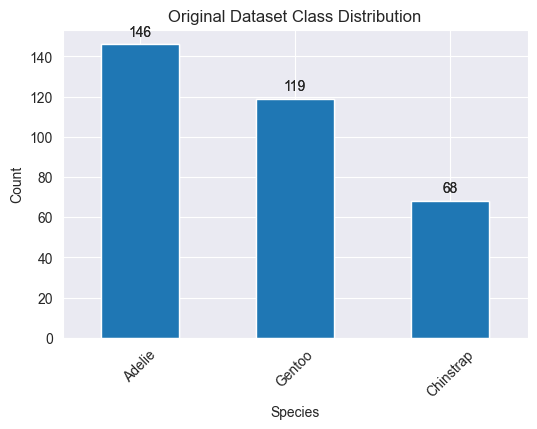

In [44]:
plt.figure(figsize=(6,4))
ax = label.value_counts().plot(kind='bar')

label.value_counts().plot(kind='bar')
plt.title("Original Dataset Class Distribution")
plt.xlabel("Species")
plt.ylabel("Count")
plt.tick_params(axis = 'x', rotation = 45)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')
plt.show()


## 1.3 Split dataset
We will split the data according to the ratios 60/40, 40/60, 20/80, 10/90, with a fixed random_state of 0.

In [45]:
split_ratios = [0.4, 0.6, 0.8, 0.9]
random_state = [0]

datasets = []


for ratio in split_ratios:
    for seed in random_state:
        feature_train, feature_test, label_train, label_test = train_test_split(
            feature_encoded, label,
            train_size = ratio,
            random_state = seed,
            shuffle = True,
            stratify = label,
        )

        datasets.append({
            'ratio': ratio,
            'seed': seed,
            'feature_train': feature_train,
            'feature_test': feature_test,
            'label_train': label_train,
            'label_test': label_test,
        })


#### 1.4 Visualizing the Train Dataset and Test Dataset
In the chart, the left bars (in blue) represent the training set distribution, while the right bars (in red) show the test set distribution.

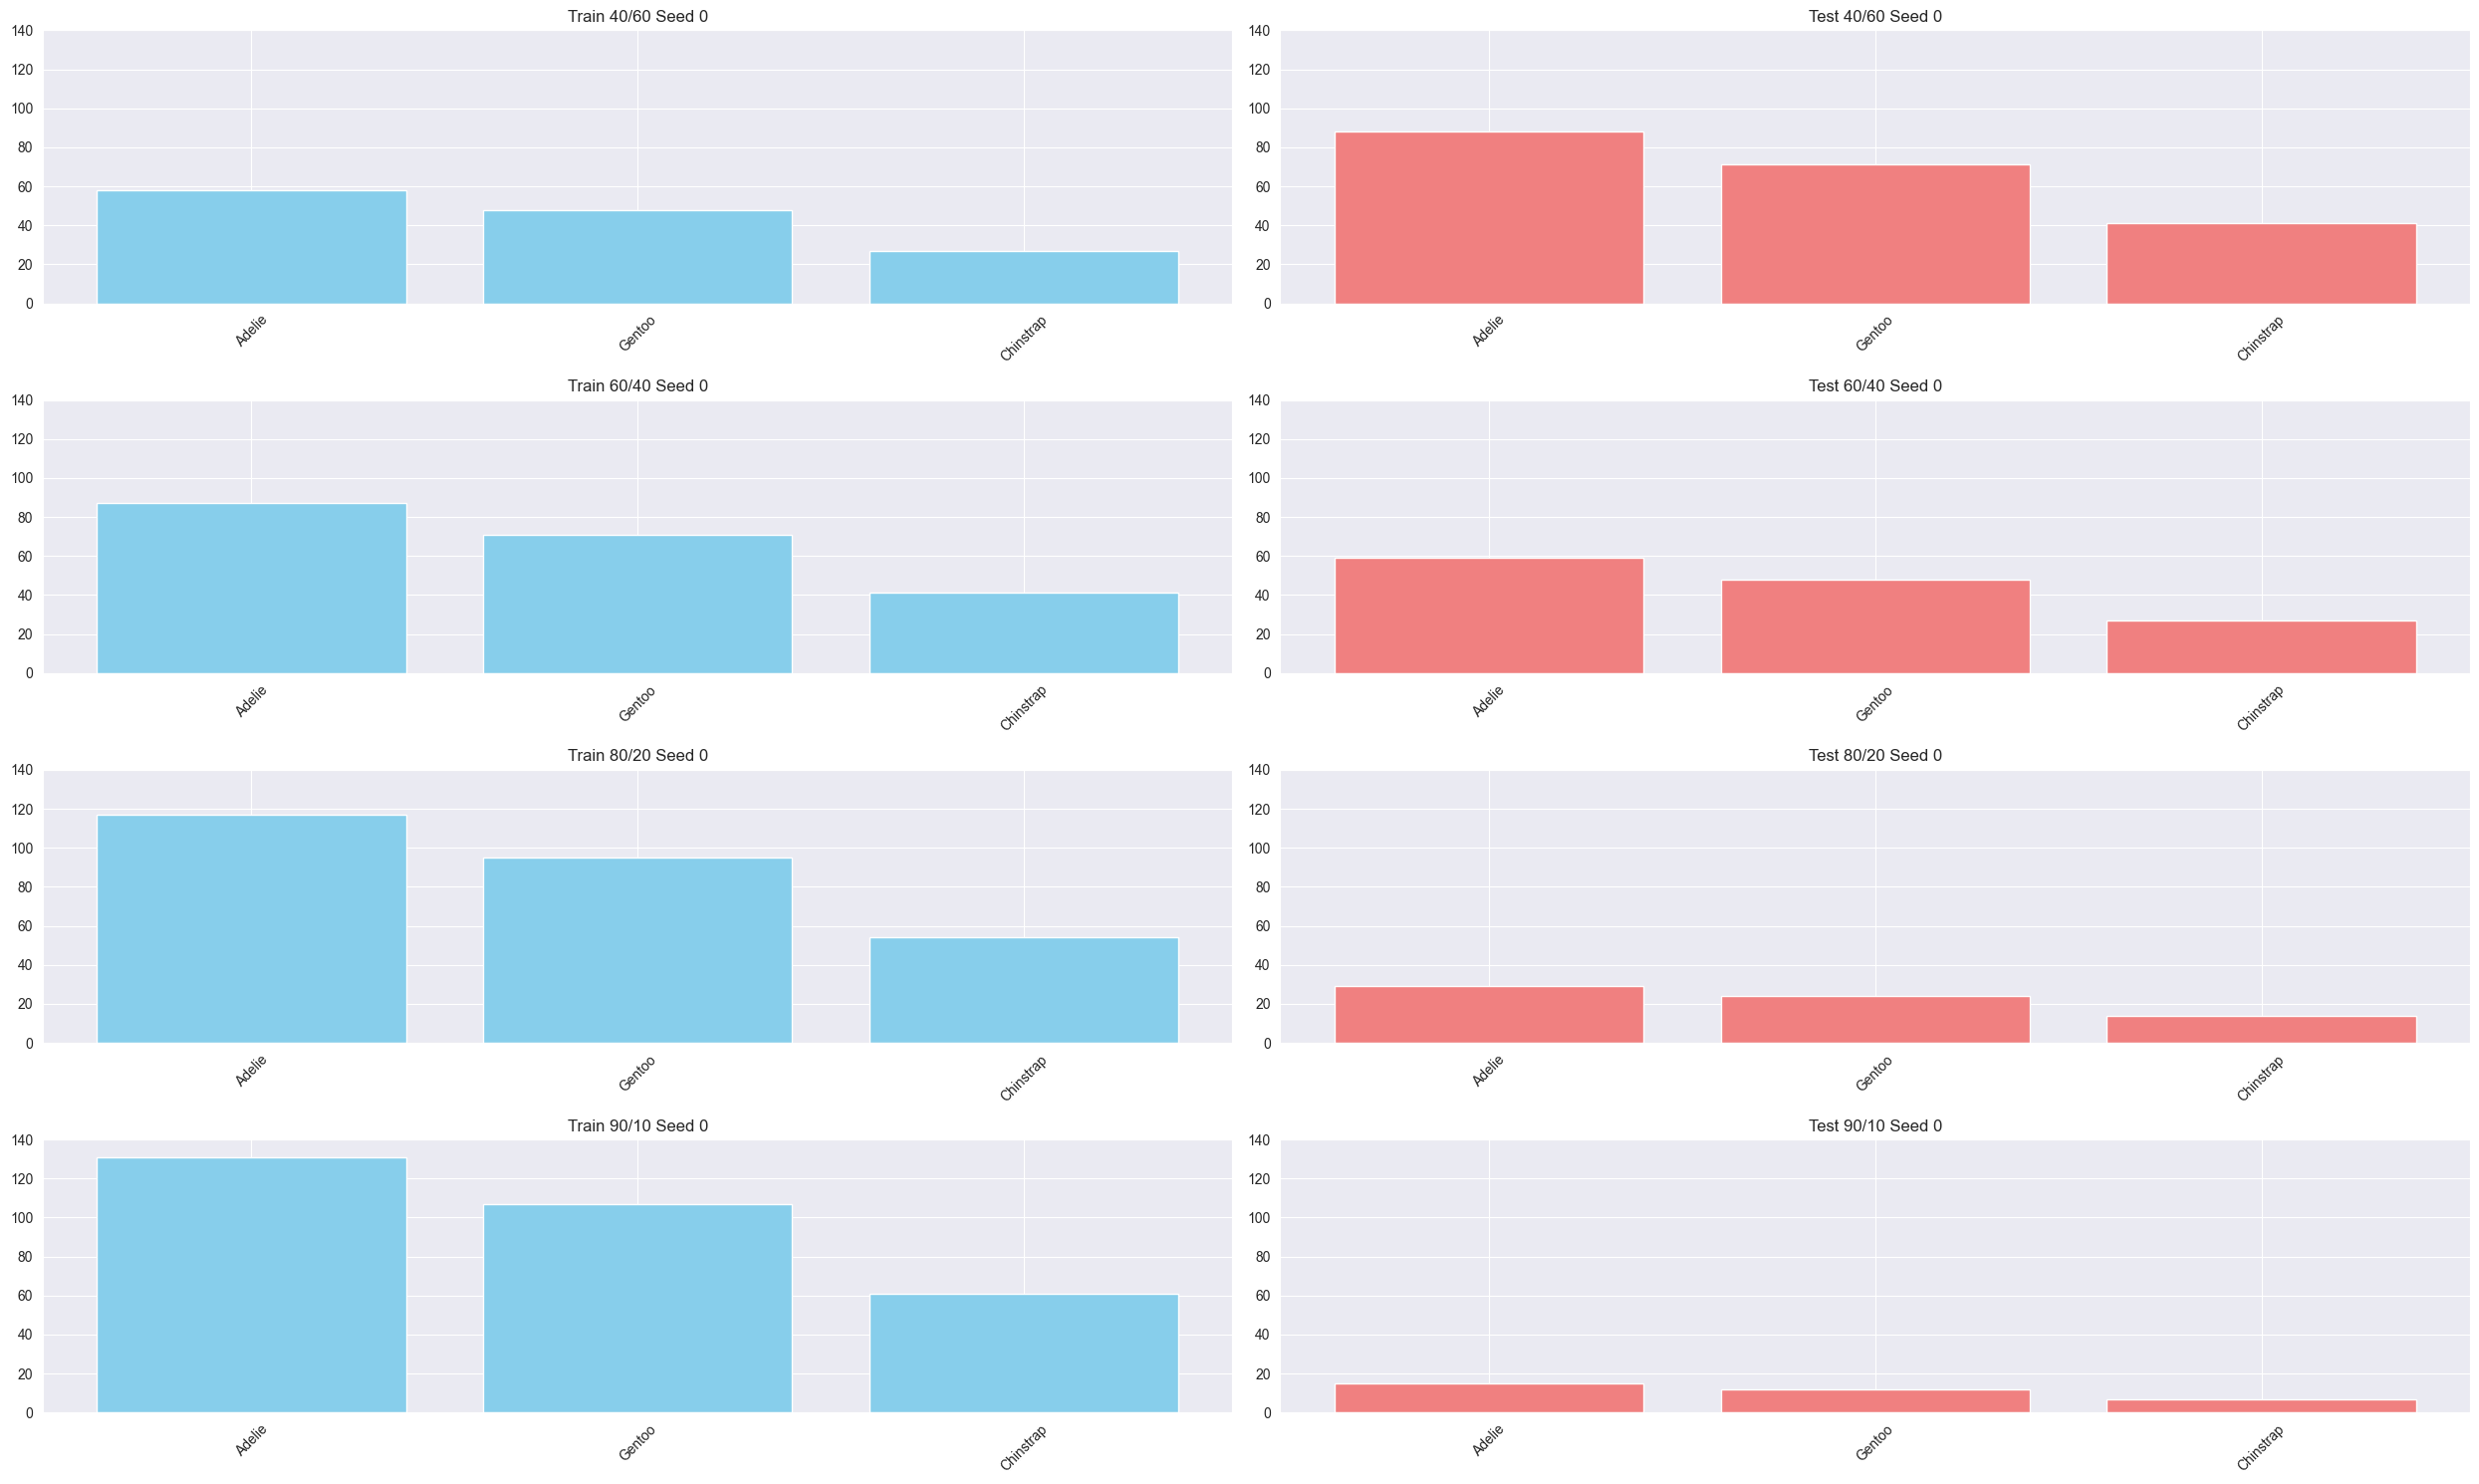

In [46]:
fig, axes = plt.subplots(len(split_ratios), len(random_state)*2, figsize=(25, 15))

for idx, dataset in enumerate(datasets):
    row = idx // len(random_state)
    col = (idx % len(random_state)) * 2

    # Training set plot
    axes[row, col].bar(dataset['label_train'].value_counts().index, dataset['label_train'].value_counts().values, color='skyblue')
    axes[row, col].set_title(f"Train {int(dataset['ratio']*100)}/{100-int(dataset['ratio']*100)} Seed {dataset['seed']}")
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].set_ylim(0, 140)

    # Testing set plot
    axes[row, col + 1].bar(dataset['label_test'].value_counts().index, dataset['label_test'].value_counts().values, color='lightcoral')
    axes[row, col + 1].set_title(f"Test {int(dataset['ratio']*100)}/{100-int(dataset['ratio']*100)} Seed {dataset['seed']}")
    axes[row, col + 1].tick_params(axis='x', rotation=45)
    axes[row, col + 1].set_ylim(0, 140)

plt.tight_layout()
plt.show()


### 2. Building the Decision Tree Classifiers
#### 2.1 Training the Decision Tree
We train a **DecisionTreeClassifier** from `sklearn.tree` on each training dataset using the information gain criterion. After training, we visualize the resulting decision tree with **Graphviz**, which provides a clear representation of the model's decision-making process.


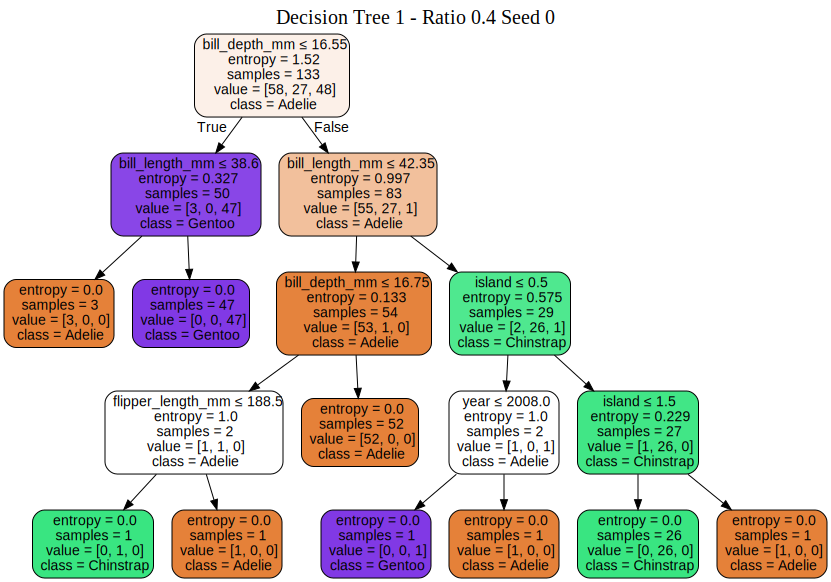

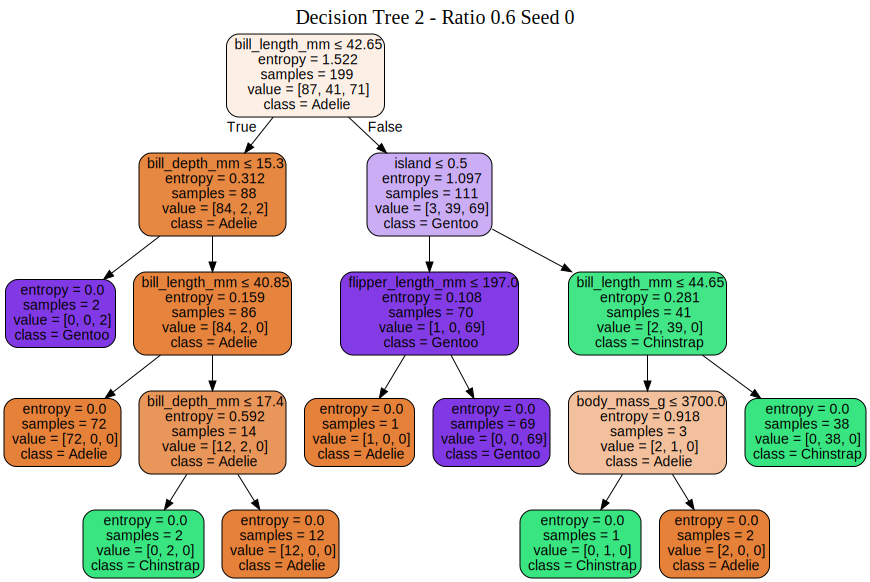

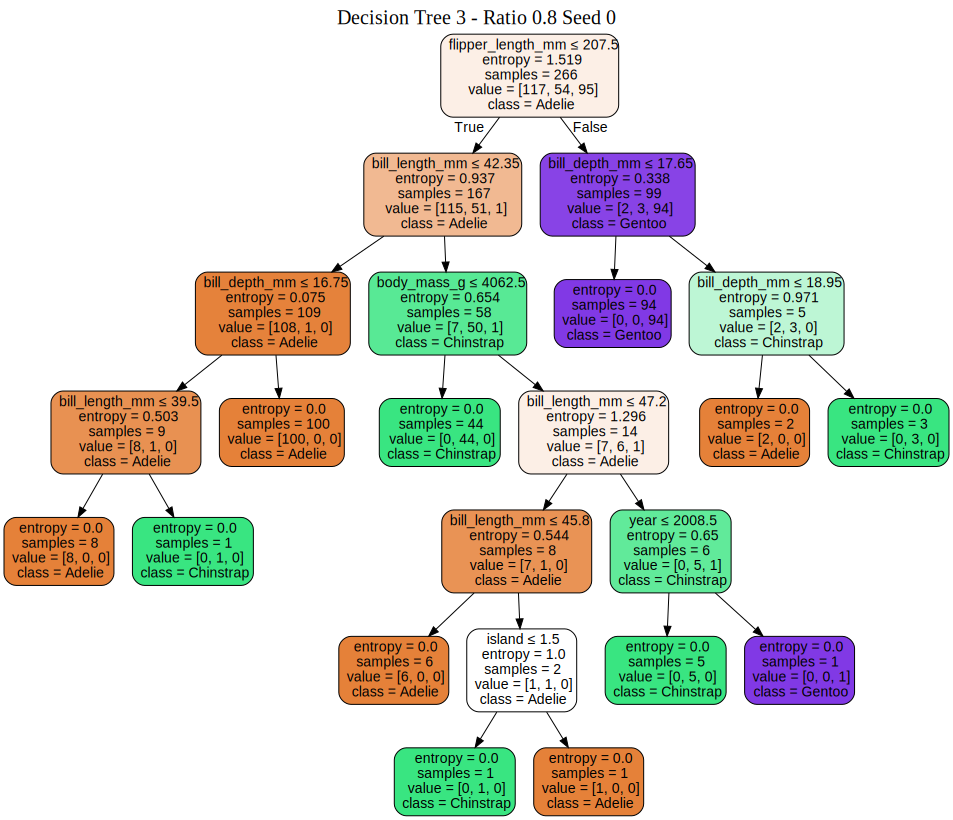

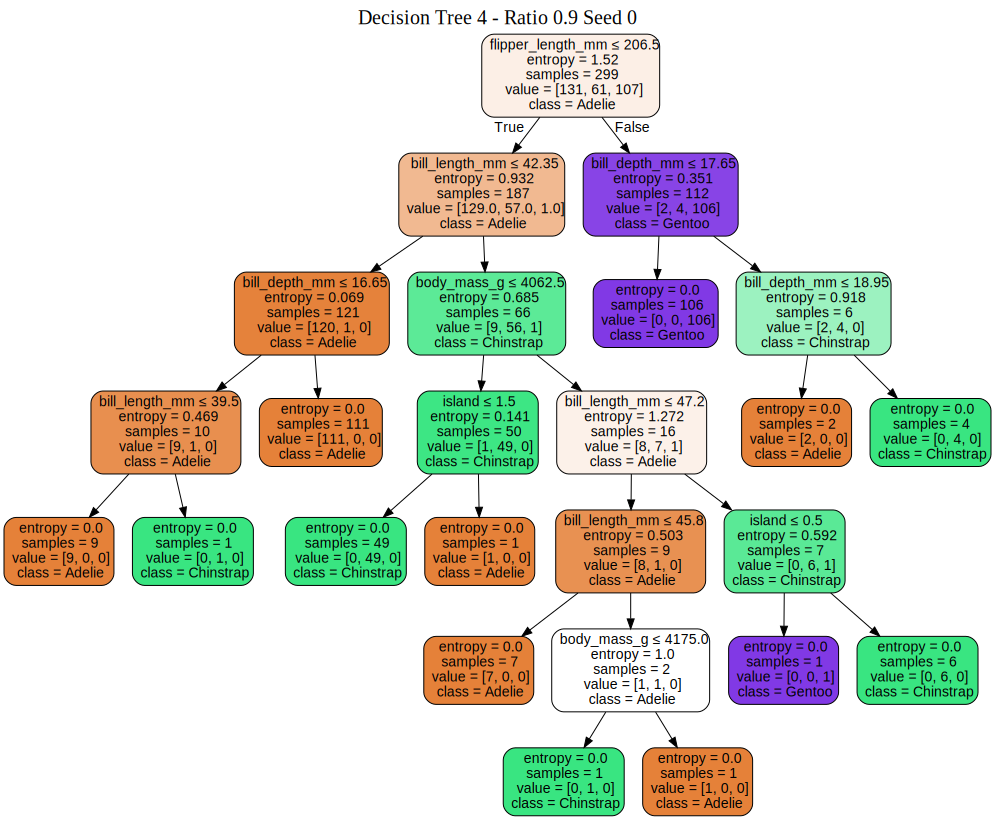

In [47]:
from sklearn.tree import export_graphviz
import graphviz

models = []

for i, example in enumerate(datasets):
    # Train model
    model = DecisionTreeClassifier(random_state=example['seed'], criterion='entropy')
    model.fit(example['feature_train'], example['label_train'])
    models.append(model)

    # Export Graphviz data
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=feature_encoded.columns,
        class_names=[str(c) for c in model.classes_],
        filled=True,
        rounded=True,
        special_characters=True
    )

    # Create a Graphviz source object
    graph = graphviz.Source(dot_data)

    # Optional: add custom title to the graph by inserting directly into dot_data
    title = f"Decision Tree {i+1} - Ratio {example['ratio']} Seed {example['seed']}"
    dot_lines = dot_data.split('\n')
    dot_lines.insert(1, f'label="{title}"; labelloc=top; fontsize=20;')  # Add graph label
    graph = graphviz.Source('\n'.join(dot_lines))

    # Display graph
    display(graph)


#### 2.2 Evaluating the Decision Tree Classifiers
After training the decision tree classifiers, it is crucial to assess their performance. We evaluate the models using a variety of metrics, such as accuracy, precision, recall, and F1-score. Additionally, we generate the **confusion matrix** to visualize the classification results and identify areas where the model may be underperforming. These evaluation steps help ensure that the decision tree models are both accurate and reliable for real-world applications.



--- Evaluation for Model 1 — Ratio 0.4 — Seed 0 ---
Accuracy: 0.9500

Classification Report:
              precision    recall  f1-score   support

      Adelie       0.95      0.95      0.95        88
   Chinstrap       0.91      0.95      0.93        41
      Gentoo       0.97      0.94      0.96        71

    accuracy                           0.95       200
   macro avg       0.94      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



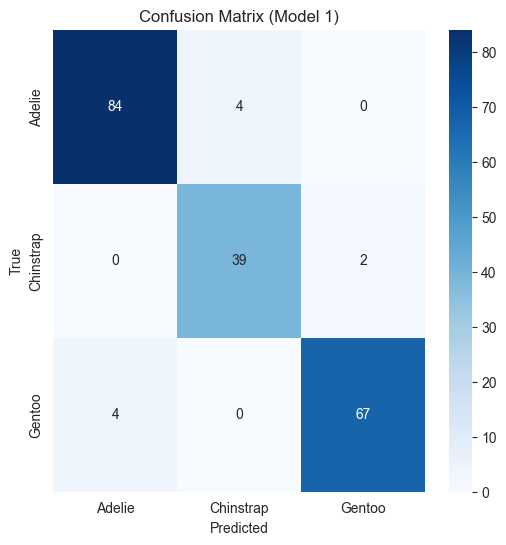


--- Evaluation for Model 2 — Ratio 0.6 — Seed 0 ---
Accuracy: 0.9701

Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      0.93      0.96        59
   Chinstrap       0.87      1.00      0.93        27
      Gentoo       1.00      1.00      1.00        48

    accuracy                           0.97       134
   macro avg       0.96      0.98      0.97       134
weighted avg       0.97      0.97      0.97       134



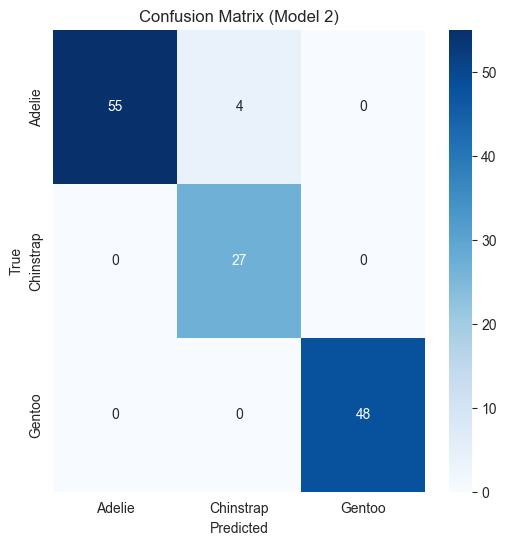


--- Evaluation for Model 3 — Ratio 0.8 — Seed 0 ---
Accuracy: 0.9552

Classification Report:
              precision    recall  f1-score   support

      Adelie       0.97      0.97      0.97        29
   Chinstrap       0.93      0.93      0.93        14
      Gentoo       0.96      0.96      0.96        24

    accuracy                           0.96        67
   macro avg       0.95      0.95      0.95        67
weighted avg       0.96      0.96      0.96        67



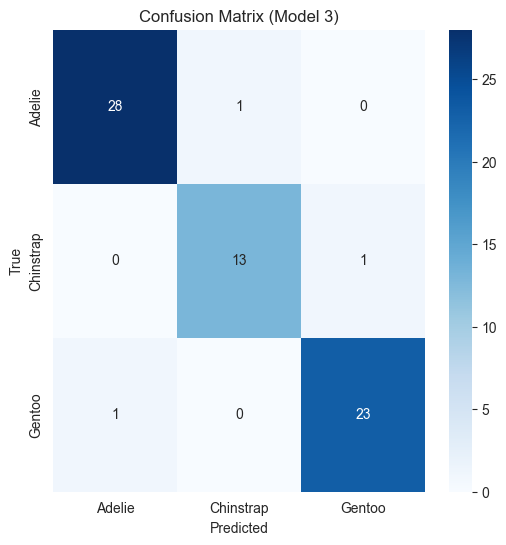


--- Evaluation for Model 4 — Ratio 0.9 — Seed 0 ---
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        15
   Chinstrap       1.00      1.00      1.00         7
      Gentoo       1.00      1.00      1.00        12

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34



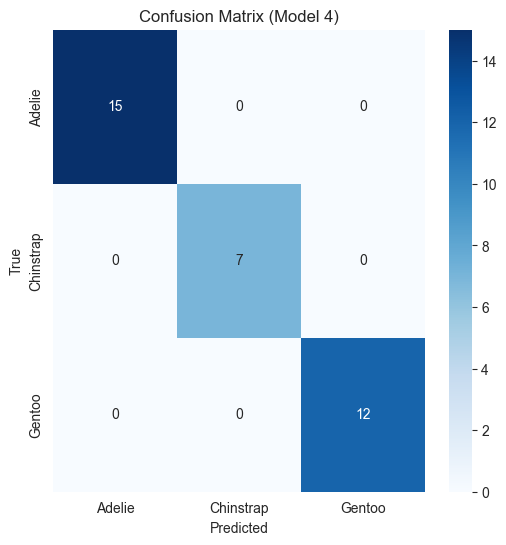

In [48]:
for i, model in enumerate(models):
    example = datasets[i]
    X_test = example['feature_test']
    y_test = example['label_test']

    # Predict and compute accuracy
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n--- Evaluation for Model {i+1} — Ratio {example['ratio']} — Seed {example['seed']} ---")
    print(f"Accuracy: {acc:.4f}\n")

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"Confusion Matrix (Model {i+1})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

#### 2.3 The depth and accuracy of a decision tree

digraph Tree {
label="Decision Tree (max_depth=None) - Accuracy: 0.96"; labelloc=top; fontsize=20;
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label=<flipper_length_mm &le; 207.5<br/>entropy = 1.519<br/>samples = 266<br/>value = [117, 54, 95]<br/>class = Adelie>, fillcolor="#fcefe6"] ;
1 [label=<bill_length_mm &le; 42.35<br/>entropy = 0.937<br/>samples = 167<br/>value = [115, 51, 1]<br/>class = Adelie>, fillcolor="#f1b992"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label=<bill_depth_mm &le; 16.75<br/>entropy = 0.075<br/>samples = 109<br/>value = [108, 1, 0]<br/>class = Adelie>, fillcolor="#e5823b"] ;
1 -> 2 ;
3 [label=<bill_length_mm &le; 39.5<br/>entropy = 0.503<br/>samples = 9<br/>value = [8, 1, 0]<br/>class = Adelie>, fillcolor="#e89152"] ;
2 -> 3 ;
4 [label=<entropy = 0.0<br/>samples = 8<br/>value = [8, 0, 0]<br/>class = Adelie>, fillcolor="#e58139"] ;
3 -> 4 ;
5 [label=<entropy = 0.0<br/

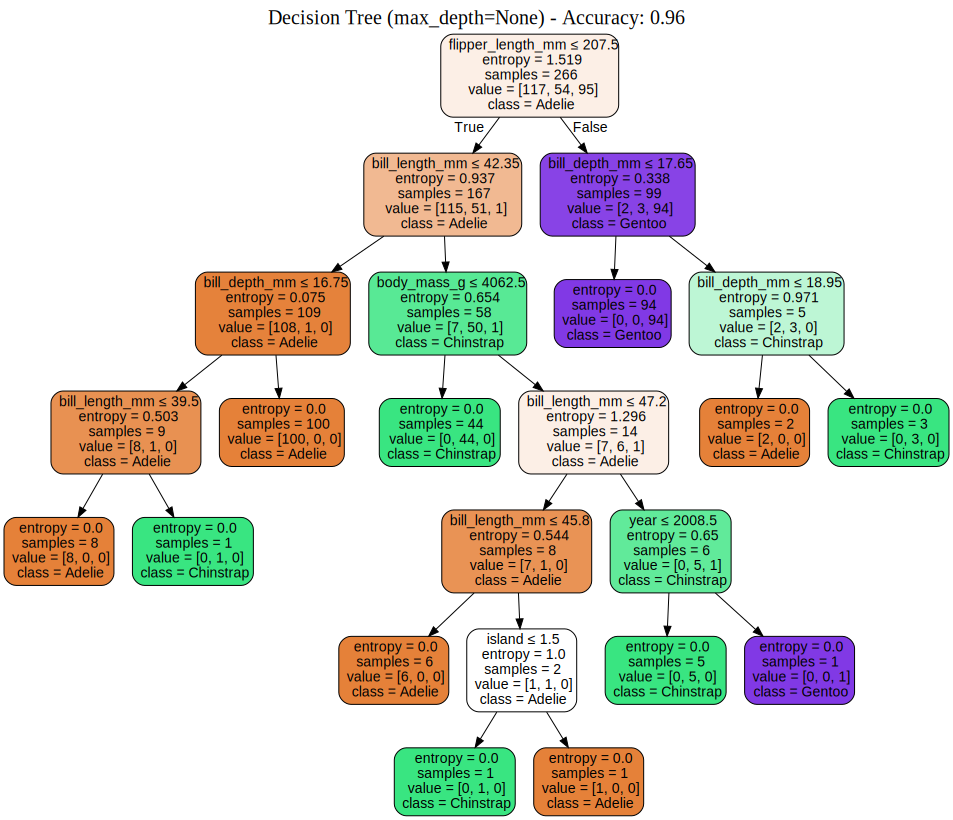

digraph Tree {
label="Decision Tree (max_depth=2) - Accuracy: 0.93"; labelloc=top; fontsize=20;
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label=<flipper_length_mm &le; 207.5<br/>entropy = 1.519<br/>samples = 266<br/>value = [117, 54, 95]<br/>class = Adelie>, fillcolor="#fcefe6"] ;
1 [label=<bill_length_mm &le; 42.35<br/>entropy = 0.937<br/>samples = 167<br/>value = [115, 51, 1]<br/>class = Adelie>, fillcolor="#f1b992"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label=<entropy = 0.075<br/>samples = 109<br/>value = [108, 1, 0]<br/>class = Adelie>, fillcolor="#e5823b"] ;
1 -> 2 ;
3 [label=<entropy = 0.654<br/>samples = 58<br/>value = [7, 50, 1]<br/>class = Chinstrap>, fillcolor="#58e995"] ;
1 -> 3 ;
4 [label=<island &le; 0.5<br/>entropy = 0.338<br/>samples = 99<br/>value = [2, 3, 94]<br/>class = Gentoo>, fillcolor="#8843e6"] ;
0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [l

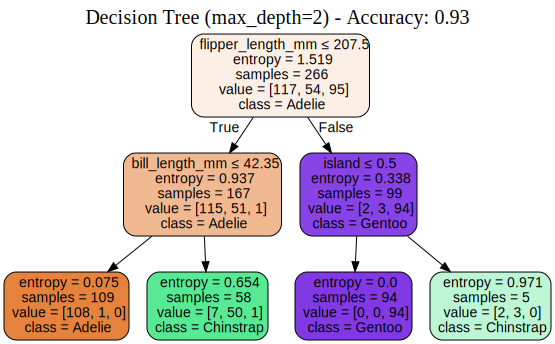

digraph Tree {
label="Decision Tree (max_depth=3) - Accuracy: 0.94"; labelloc=top; fontsize=20;
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label=<flipper_length_mm &le; 207.5<br/>entropy = 1.519<br/>samples = 266<br/>value = [117, 54, 95]<br/>class = Adelie>, fillcolor="#fcefe6"] ;
1 [label=<bill_length_mm &le; 42.35<br/>entropy = 0.937<br/>samples = 167<br/>value = [115, 51, 1]<br/>class = Adelie>, fillcolor="#f1b992"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label=<bill_depth_mm &le; 16.75<br/>entropy = 0.075<br/>samples = 109<br/>value = [108, 1, 0]<br/>class = Adelie>, fillcolor="#e5823b"] ;
1 -> 2 ;
3 [label=<entropy = 0.503<br/>samples = 9<br/>value = [8, 1, 0]<br/>class = Adelie>, fillcolor="#e89152"] ;
2 -> 3 ;
4 [label=<entropy = 0.0<br/>samples = 100<br/>value = [100, 0, 0]<br/>class = Adelie>, fillcolor="#e58139"] ;
2 -> 4 ;
5 [label=<body_mass_g &le; 4062.5<br/>entropy = 0.654<b

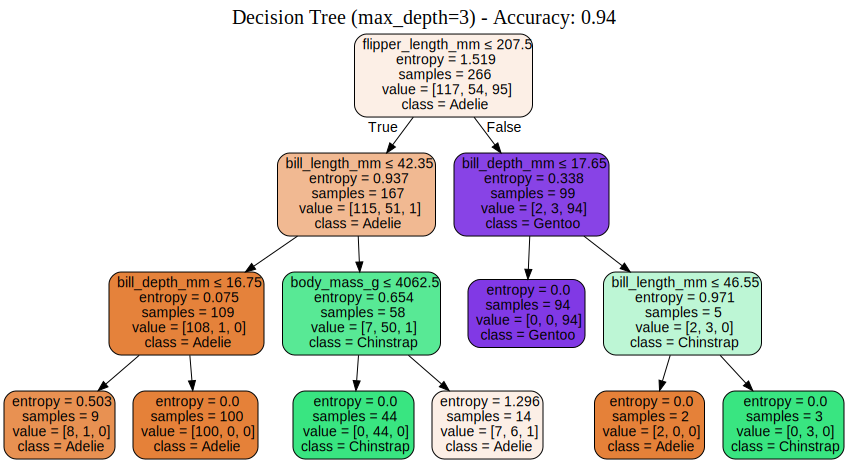

digraph Tree {
label="Decision Tree (max_depth=4) - Accuracy: 0.97"; labelloc=top; fontsize=20;
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label=<flipper_length_mm &le; 207.5<br/>entropy = 1.519<br/>samples = 266<br/>value = [117, 54, 95]<br/>class = Adelie>, fillcolor="#fcefe6"] ;
1 [label=<bill_length_mm &le; 42.35<br/>entropy = 0.937<br/>samples = 167<br/>value = [115, 51, 1]<br/>class = Adelie>, fillcolor="#f1b992"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label=<bill_depth_mm &le; 16.75<br/>entropy = 0.075<br/>samples = 109<br/>value = [108, 1, 0]<br/>class = Adelie>, fillcolor="#e5823b"] ;
1 -> 2 ;
3 [label=<bill_length_mm &le; 39.5<br/>entropy = 0.503<br/>samples = 9<br/>value = [8, 1, 0]<br/>class = Adelie>, fillcolor="#e89152"] ;
2 -> 3 ;
4 [label=<entropy = 0.0<br/>samples = 8<br/>value = [8, 0, 0]<br/>class = Adelie>, fillcolor="#e58139"] ;
3 -> 4 ;
5 [label=<entropy = 0.0<br/>sa

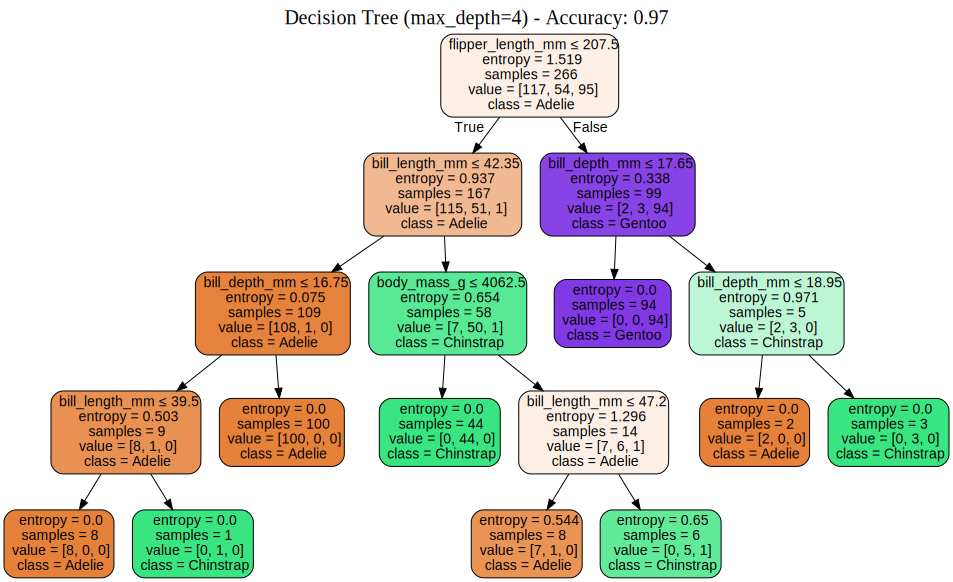

digraph Tree {
label="Decision Tree (max_depth=5) - Accuracy: 0.97"; labelloc=top; fontsize=20;
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label=<flipper_length_mm &le; 207.5<br/>entropy = 1.519<br/>samples = 266<br/>value = [117, 54, 95]<br/>class = Adelie>, fillcolor="#fcefe6"] ;
1 [label=<bill_length_mm &le; 42.35<br/>entropy = 0.937<br/>samples = 167<br/>value = [115, 51, 1]<br/>class = Adelie>, fillcolor="#f1b992"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label=<bill_depth_mm &le; 16.75<br/>entropy = 0.075<br/>samples = 109<br/>value = [108, 1, 0]<br/>class = Adelie>, fillcolor="#e5823b"] ;
1 -> 2 ;
3 [label=<bill_length_mm &le; 39.5<br/>entropy = 0.503<br/>samples = 9<br/>value = [8, 1, 0]<br/>class = Adelie>, fillcolor="#e89152"] ;
2 -> 3 ;
4 [label=<entropy = 0.0<br/>samples = 8<br/>value = [8, 0, 0]<br/>class = Adelie>, fillcolor="#e58139"] ;
3 -> 4 ;
5 [label=<entropy = 0.0<br/>sa

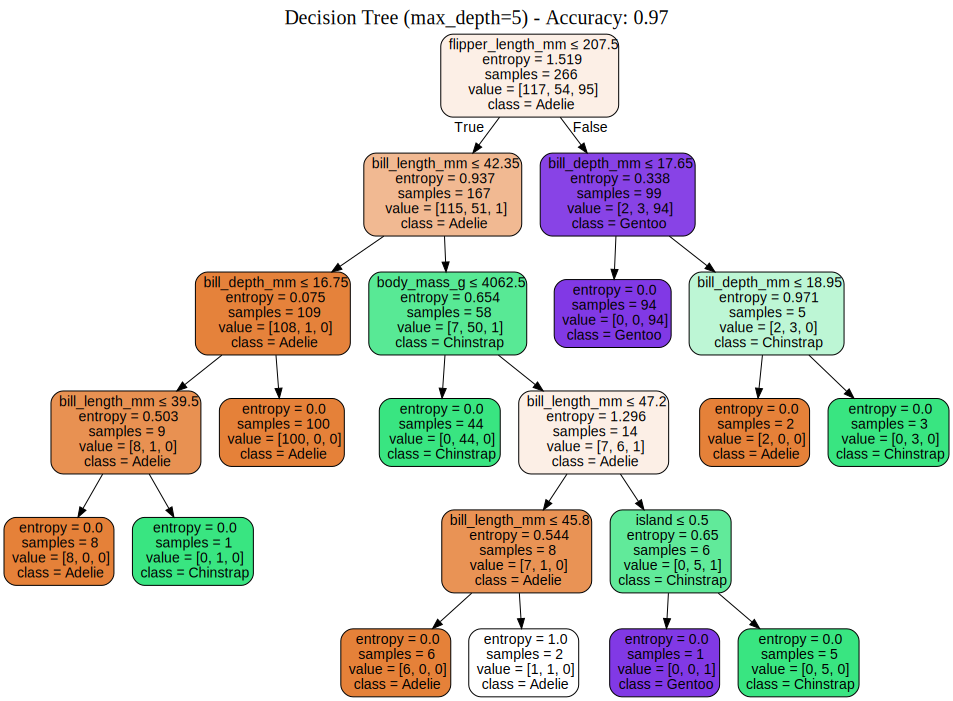

digraph Tree {
label="Decision Tree (max_depth=6) - Accuracy: 0.96"; labelloc=top; fontsize=20;
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label=<flipper_length_mm &le; 207.5<br/>entropy = 1.519<br/>samples = 266<br/>value = [117, 54, 95]<br/>class = Adelie>, fillcolor="#fcefe6"] ;
1 [label=<bill_length_mm &le; 42.35<br/>entropy = 0.937<br/>samples = 167<br/>value = [115, 51, 1]<br/>class = Adelie>, fillcolor="#f1b992"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label=<bill_depth_mm &le; 16.75<br/>entropy = 0.075<br/>samples = 109<br/>value = [108, 1, 0]<br/>class = Adelie>, fillcolor="#e5823b"] ;
1 -> 2 ;
3 [label=<bill_length_mm &le; 39.5<br/>entropy = 0.503<br/>samples = 9<br/>value = [8, 1, 0]<br/>class = Adelie>, fillcolor="#e89152"] ;
2 -> 3 ;
4 [label=<entropy = 0.0<br/>samples = 8<br/>value = [8, 0, 0]<br/>class = Adelie>, fillcolor="#e58139"] ;
3 -> 4 ;
5 [label=<entropy = 0.0<br/>sa

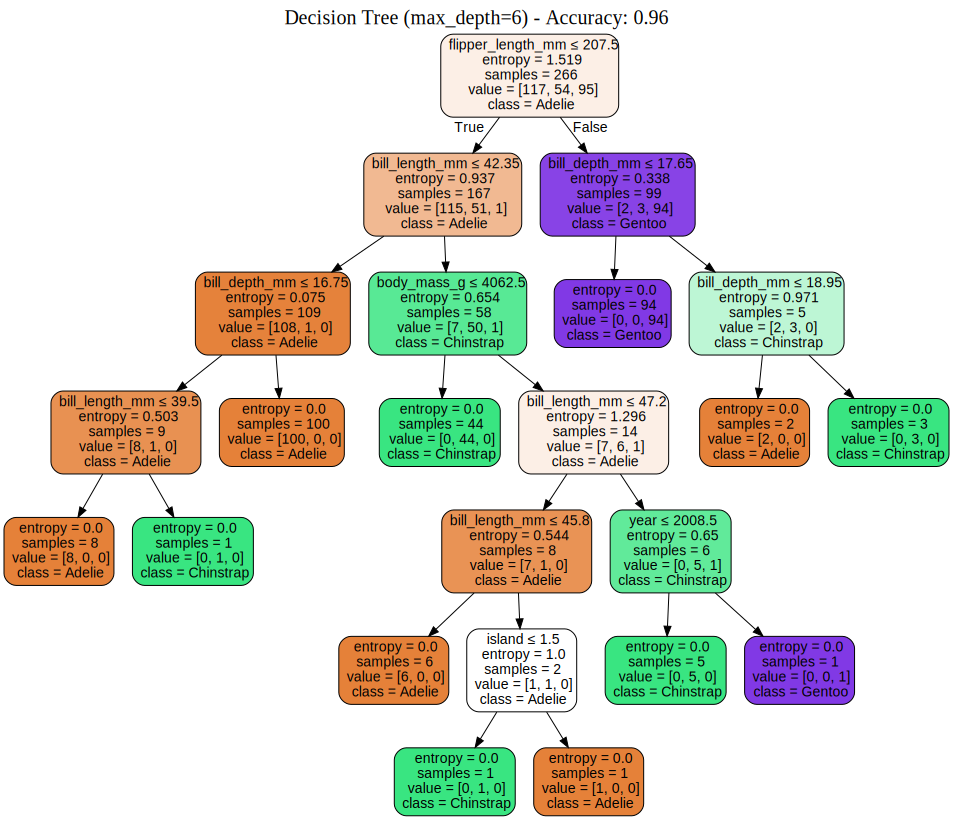

digraph Tree {
label="Decision Tree (max_depth=7) - Accuracy: 0.96"; labelloc=top; fontsize=20;
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label=<flipper_length_mm &le; 207.5<br/>entropy = 1.519<br/>samples = 266<br/>value = [117, 54, 95]<br/>class = Adelie>, fillcolor="#fcefe6"] ;
1 [label=<bill_length_mm &le; 42.35<br/>entropy = 0.937<br/>samples = 167<br/>value = [115, 51, 1]<br/>class = Adelie>, fillcolor="#f1b992"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label=<bill_depth_mm &le; 16.75<br/>entropy = 0.075<br/>samples = 109<br/>value = [108, 1, 0]<br/>class = Adelie>, fillcolor="#e5823b"] ;
1 -> 2 ;
3 [label=<bill_length_mm &le; 39.5<br/>entropy = 0.503<br/>samples = 9<br/>value = [8, 1, 0]<br/>class = Adelie>, fillcolor="#e89152"] ;
2 -> 3 ;
4 [label=<entropy = 0.0<br/>samples = 8<br/>value = [8, 0, 0]<br/>class = Adelie>, fillcolor="#e58139"] ;
3 -> 4 ;
5 [label=<entropy = 0.0<br/>sa

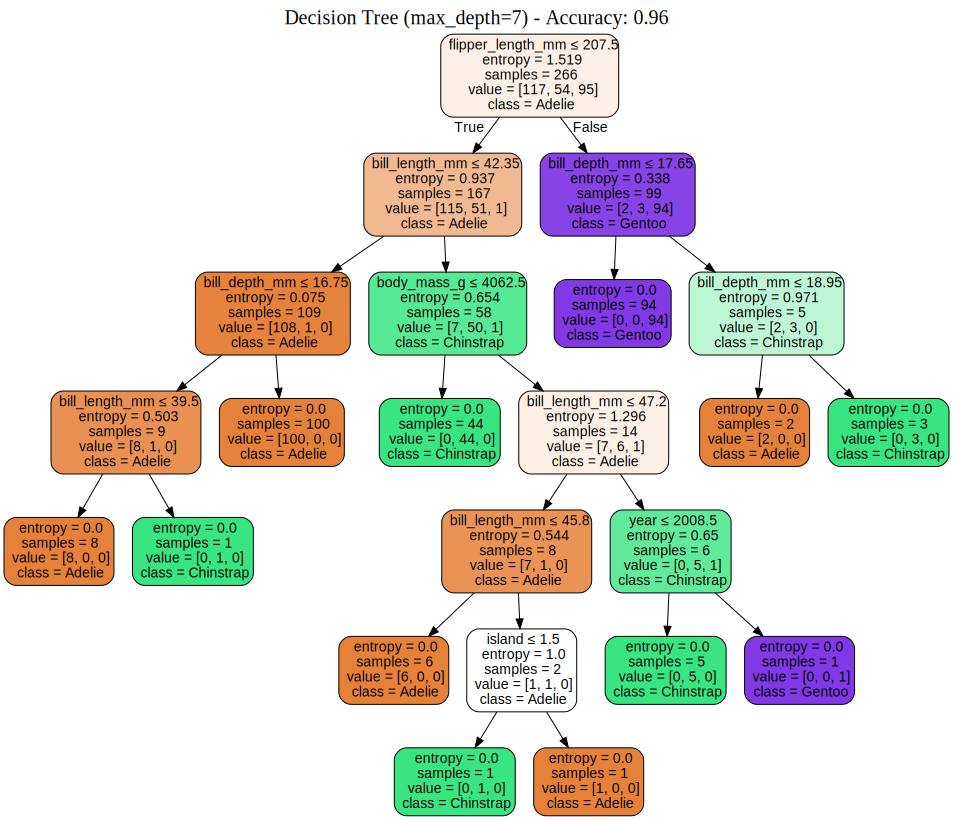


=== Accuracy Report ===
Max Depth | Accuracy
None      | 0.9552
2         | 0.9254
3         | 0.9403
4         | 0.9701
5         | 0.9701
6         | 0.9552
7         | 0.9552


In [53]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
import graphviz

example = datasets[2]  # datasets[2] is Dataset 3 (80/20)

depths = [None, 2, 3, 4, 5, 6, 7]
accuracy_results = []

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=example['seed'], criterion='entropy')
    model.fit(example['feature_train'], example['label_train'])
    y_pred = model.predict(example['feature_test'])

    acc = accuracy_score(example['label_test'], y_pred)
    accuracy_results.append((depth, acc))

    # Export to Graphviz
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=feature_encoded.columns,
        class_names=[str(c) for c in model.classes_],
        filled=True,
        rounded=True,
        special_characters=True
    )

    # Add title to the Graphviz tree
    title = f"Decision Tree (max_depth={depth}) - Accuracy: {acc:.2f}"
    dot_lines = dot_data.split('\n')
    dot_lines.insert(1, f'label="{title}"; labelloc=top; fontsize=20;')
    print('\n'.join(dot_lines))
    graph = graphviz.Source('\n'.join(dot_lines))
    display(graph)

# Print accuracy report
print("\n=== Accuracy Report ===")
print("Max Depth | Accuracy")
for depth, acc in accuracy_results:
    print(f"{str(depth):9} | {acc:.4f}")


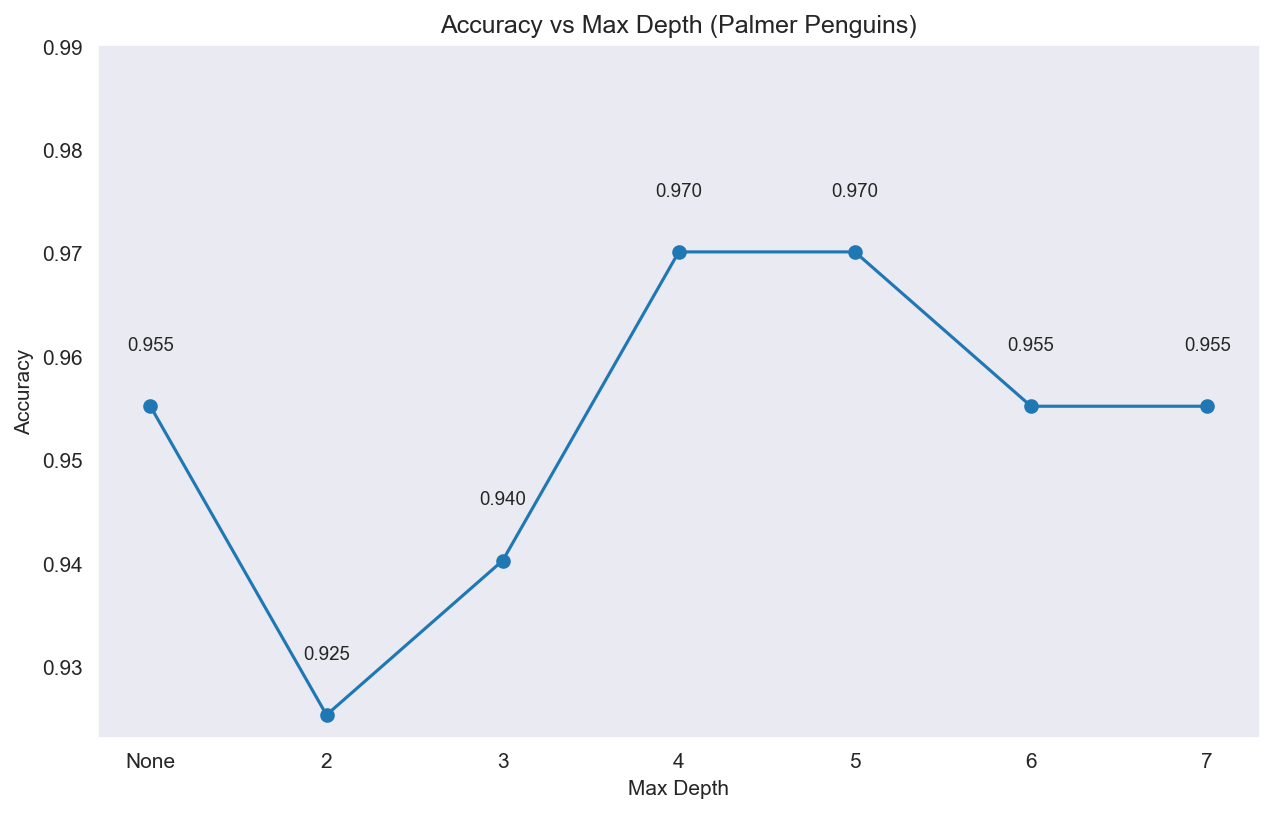

In [43]:


filtered = [(d, a) for d, a in accuracy_results if a is not None]

depths = [str(d) for d, _ in filtered]
accs = [a for _, a in filtered]

plt.figure(figsize=(10, 6), dpi=150)
plt.plot(depths, accs, marker='o')
plt.title("Accuracy vs Max Depth (Palmer Penguins)")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.ylim(top=max(accs) + 0.02)

for x, y in zip(depths, accs):
    plt.text(x, y + 0.005, f"{y:.3f}", ha='center', va='bottom', fontsize=9)

plt.grid()
plt.show()

accuracy_table = pd.DataFrame({'max_depth': depths, 'Accuracy': accs})
